# Model Initiation

In [55]:
#Libary
import pandas as pd
import os

In [56]:
import ixmp

mp = ixmp.Platform()

In [57]:
#convert mtoe to GW
conv_mtoe_gwa = 11.63*1000/8760

In [58]:
import message_ix

scenario = message_ix.Scenario(
    mp, model='Indonesia Prototype', scenario='baseline', version='new'
)

# Model Structure

<img src='Messageix Indonesia Structure.drawio.png' width='1000'>

In [59]:
historical_horizon = list(range(2005,2023,1))
model_horizon = list(range(2023,2051,1))

scenario.add_horizon(year=historical_horizon+model_horizon, firstmodelyear=2023)


In [60]:
country='IDN'
scenario.add_spatial_sets({'country':country})

In [61]:
demand_com = [
    'industry_el',
    'transport_el',
    'commercial_el',
    'residential_el'
]

commodities = [
    'coal',
    'electricity'
]

all_com = demand_com + commodities

In [62]:

ppl_tec = [
    'coal_ppl'
]

t_d_tec = [
    'electricity_grid'
           ]

demand_tec = [
    'industry_el_tec',
    'transport_el_tec',
    'commercial_el_tec',
    'residential_el_tec'
]

all_tec =  ppl_tec + t_d_tec + demand_tec

In [63]:
scenario.add_set('commodity',all_com)
scenario.add_set('level',['primary','secondary','final','useful'])
scenario.add_set('technology',all_tec)
scenario.add_set('mode','standard')
scenario.add_set('level_resource','primary')
scenario.add_set('grade','a')

## Demand Parameter

In [64]:
path = os.getcwd()
path = os.path.dirname(path)
filename = 'COPY Indonesia AEO8 Data.xlsx'
filename = os.path.join(path,filename)

sectors = ['Industry','Transport','Commercial','Residential']
sector_models = ['industry_el','transport_el','commercial_el','residential_el']

In [65]:

for sector,sector_model in zip(sectors,sector_models):

    df = pd.read_excel(filename,sheet_name=f'IDN_{sector}_BAS',skiprows=6)
    index = df[df['Fuel'] == 'Total'].index[0] #get index of the targeted sliced rows
    df = df.loc[:index-1]
    df = df.melt(id_vars='Fuel', value_vars=list(range(2005,2051,1)),var_name='Year')
    df = df[(df['Fuel'] == 'Electricity') & (df['Year']>2022)]
    df.value = df.value*conv_mtoe_gwa
    values = df.value.tolist()

    df_demand = pd.DataFrame(
        {
            'node':country,
            'commodity':f'{sector_model}',
            'level':'useful',
            'year': model_horizon,
            'time':'year',
            'value':values,
            'unit':'GWa'
        }
    )

    scenario.add_par('demand',df_demand)
    

In [ ]:
'''
electricity_d = [
    21.00799087, 21.65068493, 22.32191781, 23.03310502, 23.10844749, 23.16552511, 
    23.34589041, 23.46232877, 23.7956621, 24.1826484, 24.54680365, 24.89155251, 
    25.28652968, 25.64611872, 26.15068493, 26.65410959, 27.21461187, 27.71803653, 
    28.32762557, 28.94406393, 29.51712329, 30.16324201, 30.80022831, 31.4303653, 
    32.12442922, 32.77739726, 33.42694064, 34.06849315
]#converted to GWa

model_horizon = list(range(2023,2051,1))



electricity_demand = pd.DataFrame(
    {
        'node':country,
        'commodity':'electricity',
        'level':'final',
        'year': model_horizon,
        'time':'year',
        'value':electricity_d,
        'unit':'GWa'
    }
)

electricity_demand['value'] = electricity_demand['value'].round(decimals=2)
'''


In [65]:
'''scenario.add_par('demand',electricity_demand)'''

"scenario.add_par('demand',electricity_demand)"

## Engineering Parameters

In [66]:
year_df = scenario.vintage_and_active_years()
vintage_years,act_years = year_df["year_vtg"],year_df["year_act"]

In [67]:
base_coal_input = {
    "node_loc":country,
    "year_vtg":vintage_years,
    "year_act":act_years,
    "mode":"standard",
    "node_origin":country,
    "commodity":"coal",
    "time":"year",
    "time_origin":"year"
}

coal_ppl = pd.DataFrame(
    dict(
        technology='coal_ppl',
        level='primary',
        value=1,
        unit='-',
        **base_coal_input,
    )
)

scenario.add_par("input",coal_ppl)



In [68]:
from message_ix import make_df

#Electricity Input
base_electr_input = {
    "node_loc":country,
    "year_vtg":vintage_years,
    "year_act":act_years,
    "mode":"standard",
    "node_origin":country,
    "commodity":"electricity",
    "time":"year",
    "time_origin":"year"
}

electr_grid = make_df(
    base_electr_input,
    technology='electricity_grid',
    level='secondary',
    value=1,
    unit='-',
)

scenario.add_par("input",electr_grid)

for tec in demand_tec:
    electr_in = make_df(
        base_electr_input,
        technology = f'{tec}',
        level = 'final',
        value=1,
        unit ='-'
    )
    scenario.add_par('input',electr_in)
    



In [70]:
coal_ppl_eff = 0.34 #Data from EBT
electr_grid_eff = 1


#Output
base_output = {
'node_loc':country,
'year_vtg':vintage_years,
'year_act':act_years,
'mode':'standard',
'node_dest':country,
'time':'year',
'time_dest':'year',   
}



#coal_ppl
coal_ppl = make_df(
    base_output,
    technology ='coal_ppl',
    commodity ='electricity',
    level = 'secondary',
    value = coal_ppl_eff, 
    unit = '-'
    
)


#electricity grid
electr_grid = make_df(
    base_output,
    technology ='electricity_grid',
    commodity ='electricity',
    level = 'final',
    value = electr_grid_eff, 
    unit = '-'
)

scenario.add_par("output",coal_ppl)
scenario.add_par("output",electr_grid)

for tec,com in zip(demand_tec,demand_com):
    electr_out = make_df(
        base_output,
        technology = f'{tec}',
        commodity = f'{com}',
        level = 'useful',
        value=1,
        unit ='-'
    )
    scenario.add_par('output',electr_out)

In [72]:
#Technical Lifetime (data from tutorial)

technical_lifetime = make_df("technical_lifetime",
    node_loc = country,
    year_vtg = vintage_years,
    unit = 'y',
    technology = 'coal_ppl',
    value = 40,
)

scenario.add_par('technical_lifetime',technical_lifetime)

In [73]:
#Capacity Factor (data from tutorial)
coal_ppl_cf = 0.8

capacity_factor = make_df(
   'capacity_factor',
    node_loc = country,
    year_vtg = vintage_years,
    year_act = act_years,
    time = 'year',
    unit = '-',
    technology = 'coal_ppl',
    value = coal_ppl_cf
)

scenario.add_par('capacity_factor',capacity_factor)

## Technoeconomic Parameters

In [74]:
#Resource parameters

potentials = {'a':[133575,10,638.85]} #based on RUKN (potential) and HEESI 2022 (last historical extraction), cost based on tutorial

df = pd.DataFrame(
    {
        'node': [country],
        'commodity':'coal',
        'grade':'a',
        'value':potentials['a'][0]
    }
)
scenario.add_par('resource_volume',df)

mp.add_unit('USD/KWa')
df = make_df(
    'resource_cost',
    node = country,
    commodity='coal',
    grade='a',
    year = model_horizon,
    value=potentials['a'][1],
    unit='USD/KWa'
)

scenario.add_par('resource_cost',df)

df = pd.DataFrame(
    {
        'node': country,
        'commodity':'coal',
        'grade':'a',
        'year':[2022],
        'value':potentials['a'][2],
        'unit':'GWa'
    }
)
scenario.add_par('historical_extraction',df)





In [75]:
#inv_cost (data from tutorial)

inv_cost = make_df(
    "inv_cost",
    node_loc = country,
    year_vtg = vintage_years,
    unit = 'USD/kW',
    technology = 'coal_ppl',
    value=1500,
)

mp.add_unit('USD/kW')

scenario.add_par('inv_cost',inv_cost)

In [76]:
#fix_cost (data from tutorial)

fix_cost = make_df(
    "fix_cost",
    node_loc = country,
    year_vtg = vintage_years,
    year_act = act_years,
    unit = 'USD/kWa',
    technology = 'coal_ppl',
    value=40,
)

mp.add_unit('USD/kWa')

scenario.add_par('fix_cost',fix_cost)

In [77]:
#var_cost (data from tutorial)

var_cost = make_df(
    "var_cost",
    node_loc = country,
    year_vtg = vintage_years,
    year_act = act_years,
    unit = 'USD/kWa',
    mode='standard',
    time='year',
    technology = 'coal_ppl',
    value=213.744
)

scenario.add_par('var_cost',var_cost)

## Calibration Parameter

In [79]:
#2005-2022 data converted to GWa
coal_el_d_his = [
    6.947945205, 7.774315068, 8.478196347, 8.296803653, 8.653424658, 
    8.720547945, 10.13869863, 12.52591324, 13.49303653, 14.43949772, 
    15.6163242, 16.17271689, 17.42773973, 18.2663242, 19.91929224, 
    20.64714612, 21.6847032, 23.4369863
]



In [80]:
elec_tec = ['coal_ppl','electricity_grid']

for tec in elec_tec:
    df = make_df(
        'historical_activity',
        node_loc=country,
        year_act=historical_horizon,
        mode='standard',
        time='year',
        unit='GWa',
        technology = tec,
        value = coal_el_d_his
    )

    scenario.add_par('historical_activity',df)
    scenario.add_par("bound_activity_up", df)
    scenario.add_par("bound_activity_lo", df)

In [81]:
ace_coal_cap_his = [
    9.75, 11.17, 12.01, 12.29, 12.59, 12.98, 16.36, 18.28, 22.34, 
    23.64, 25.76, 27.14, 26.81, 31.59, 34.74, 36.67, 37.04, 46.04]

df = make_df(
    'historical_new_capacity',
    node_loc = country,
    year_vtg = historical_horizon,
    unit = 'GW',
    technology = 'coal_ppl',
    value=ace_coal_cap_his
)

scenario.add_par('historical_new_capacity',df)

## Objective Function

In [82]:
scenario.add_par("interestrate", model_horizon, value=0.07, unit="-")

# Commit and Solve the Model

In [83]:
comment = "initial commit for Indonesia model"
scenario.commit(comment)
scenario.set_as_default()

In [84]:
scenario.solve()

In [85]:
scenario.var("OBJ")["lvl"]


481242.21875

# Plotting Result

In [86]:
%matplotlib inline


In [87]:
from message_ix.report import Reporter
from message_ix.util.tutorial import prepare_plots

# Create a Reporter object to describe and carry out reporting
# calculations and operations (like plotting) based on `scenario`
rep = Reporter.from_scenario(scenario)

# "prepare_plots" enables several to describe reporting operations, e.g.
# "plot activity", "plot capacity", or "plot prices"
# See message_ix/util/tutorial.py for more information
prepare_plots(rep)

<IPython.core.display.Javascript object>

<Axes: title={'center': 'IDN Energy System Activity'}, xlabel='Year', ylabel='GWa'>

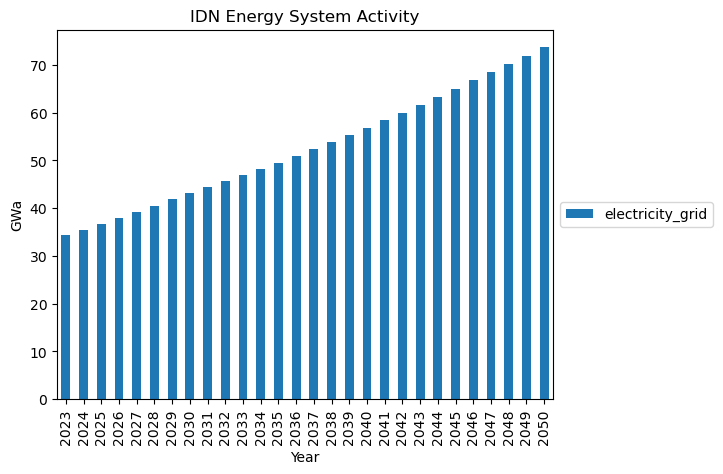

In [93]:
rep.set_filters(t=["electricity_grid"], ya=model_horizon)
rep.get("plot activity")



<Axes: title={'center': 'IDN Energy System Capacity'}, xlabel='Year', ylabel='GW'>

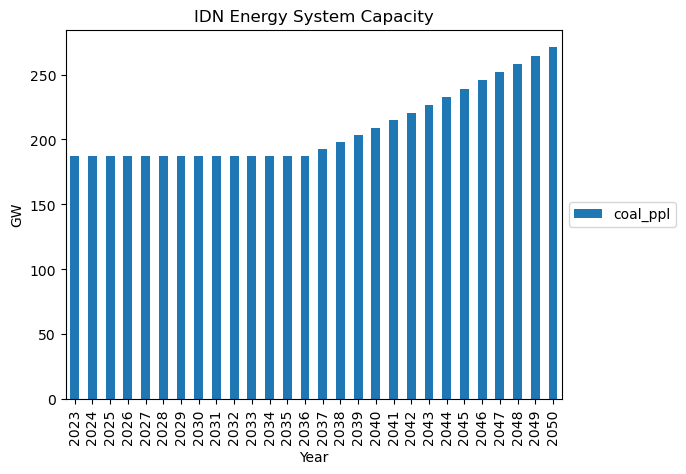

In [89]:
rep.get('plot capacity')

In [94]:
mp.close_db()